In [1]:
#importing libraries
import pandas as pd
import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import warnings
from IPython.display import clear_output, display
from PIL import Image

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from scipy import stats
import pylab

In [3]:
import statsmodels.api as sm

In [4]:
#loading data
df =pd.read_csv("insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


The data has total 6 features and a target column. It has total 1338 rows.
Also, the data contains 3 categorical features(sex,smoker and region) and 3 numeric features(age(continuous),
bmi(continuous),children(discrete))


In [6]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


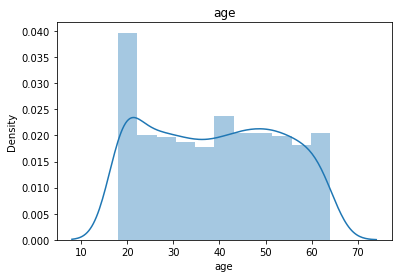

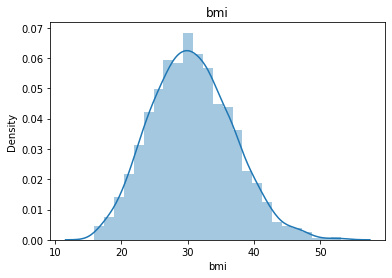

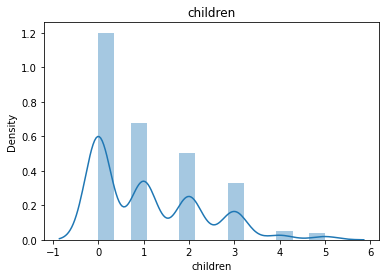

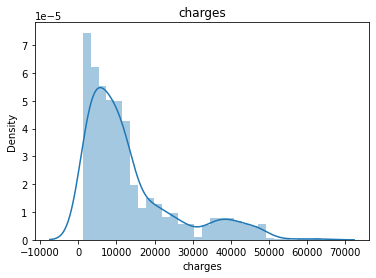

In [7]:
#plotting to see the distribution of numeric features:
for i in df.columns:
    if((df[i].dtypes=='int64') | (df[i].dtypes=='float64')):
        sns.distplot(df[i])
        plt.title(i)
        plt.show() 

In [8]:
#Is there really a normal distribution of BMI, or anything else? Let's calculate for each quantitative column! 
from scipy.stats import shapiro
def isnormal(df,column):
    stat, p=shapiro(df[column])
    if p > 0.05:
        print(f"The {column} column is likely normally distributed.")
    else:
        print(f"The {column} column  is not normally distributed.")
    return p
col = ['age','bmi','children','charges']
[isnormal(df,column) for column in col]
#It's OK, data. I'm not normal, either. 

The age column  is not normally distributed.
The bmi column  is not normally distributed.
The children column  is not normally distributed.
The charges column  is not normally distributed.


[5.687479624670986e-22,
 2.609841976664029e-05,
 5.066361280494088e-36,
 1.150477698013898e-36]

In [9]:
from scipy.stats import pearsonr
def eval_assoc(correl):
    if correl > .6:
        print(f"The correlation of {correl} suggests a strong linear association.")
    elif correl > .3:
        print(f"The correlation of {correl} suggests a linear association.")    
    elif correl < .3:
        print(f"The correlation of {correl} does not suggest a strong association.")
    return correl

corr_charges_bmi,p=pearsonr(df.charges,df.bmi)
print("Pearson for corr_charges_bmi:\n")
eval_assoc(corr_charges_bmi)
corr_charges_children,p=pearsonr(df.charges,df.children)
print("Pearson for corr_charges_children:\n")
#print(corr_charges_children)
eval_assoc(corr_charges_children)
corr_charges_age,p=pearsonr(df.charges,df.age)
print("Pearson for corr_charges_age:\n")
eval_assoc(corr_charges_age)
corr_bmi_charges,p=pearsonr(df.bmi,df.charges)
print("Pearson for corr_bmi_charges:\n")
eval_assoc(corr_bmi_charges)

Pearson for corr_charges_bmi:

The correlation of 0.1983409688336288 does not suggest a strong association.
Pearson for corr_charges_children:

The correlation of 0.0679982268479048 does not suggest a strong association.
Pearson for corr_charges_age:

The correlation of 0.2990081933306476 does not suggest a strong association.
Pearson for corr_bmi_charges:

The correlation of 0.1983409688336288 does not suggest a strong association.


0.1983409688336288

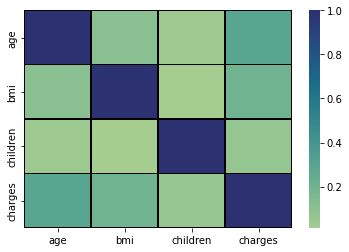

In [10]:
sns.heatmap(df.corr(),cmap="crest",linewidths=0.5,linecolor="black")

#After observing the distribution of numeric data we conclude:
1. features bmi follow normal distribution
2. target column charged has significant high number of outliers which we will tackle later with IQR met

In [12]:
#categorical features
for i in df.columns:
    if df[i].dtypes =='object':
        print(i)
        print(df[i].nunique())

sex
2
smoker
2
region
4


In [13]:
#checking missing values
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [14]:
#checking duplicated values
df.duplicated().sum()

1

In [15]:
df[df.duplicated(keep=False)]

,age,sex,bmi,children,smoker,region,charges
195,19,male,30.59,0,no,northwest,1639.5631
581,19,male,30.59,0,no,northwest,1639.5631


In [16]:
#remove duplicate values
df.drop_duplicates(inplace=True)

In [17]:
df.duplicated().sum()

0

#After observing the categorical features we conclude:
1. There are no any missing values in the data
2. There was one duplicate rows which we remove immediately.
3. Object features has relatively low cardinality which is good for modeling

In [18]:
#detecting outliers
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB


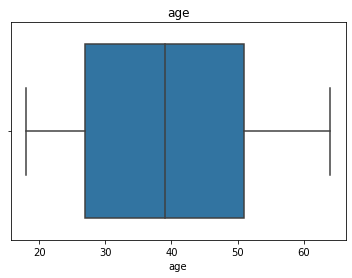

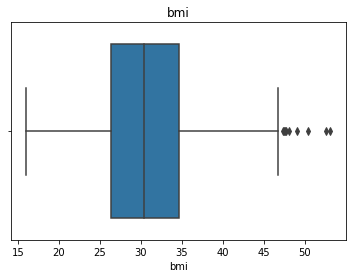

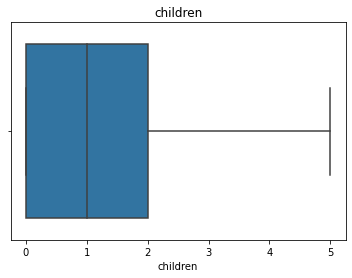

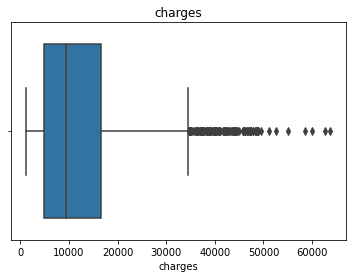

In [19]:
for i in df.columns:
    if (df[i].dtypes != 'object'):
        plt.title(i)
        sns.boxplot(df[i])
        plt.show()

In [20]:
#using IQR method determing the exact amount of outliers present in the charges column
#Any observations that are more than 1.5 IQR below Q1 or more than 1.5 IQR above Q3 are considered outliers
q1  =np.percentile(df['charges'],25)
q3 = np.percentile(df['charges'],75)
iqr = q3-q1
print(iqr)

11911.37345


In [21]:
cutoff = 1.5*iqr
lower = q1-cutoff
upper = q3+cutoff
print(f'The lower limit is {lower} and the upper limit is {upper}')

The lower limit is -13120.716174999998 and the upper limit is 34524.777625


In [22]:
#identifying the no of outliers
print('The number of above upper limits:', len(df[df['charges']>upper]))
print('The number of below lower limits:', len(df[df['charges']<lower]))

The number of above upper limits: 139
The number of below lower limits: 0


#From 1337 rows of data, we have 139 number of outliers in 'charges' features. Is like 10% + of our 'charges' features were outliers.
#Because we don't want losing any more information. We will replace the outliers with median values

In [23]:
median = np.median(df['charges'])
median

9386.1613

In [24]:
df['charges'] = np.where(df['charges'] > upper, median, df['charges'])

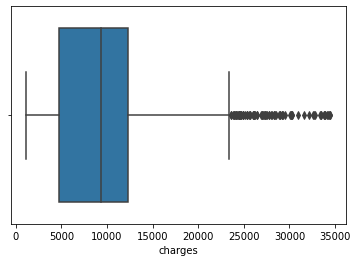

In [25]:
sns.boxplot(df['charges'])

#Data Preprocessing
1. we will split the data into train and test set
2.  we will normlaize the numeric data
3. one hot encoding of the categorical data

In [26]:
X = df.drop('charges',axis=1)
y = df['charges']

In [27]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=142) 

In [28]:
#Feature encoding of object features(categorical features)
cat_feat = ['sex','smoker','region']

In [29]:
for i in X_train[cat_feat].columns:
    ln = LabelEncoder()
    X_train[i] = ln.fit_transform(X_train[i])

In [30]:
for i in X_test[cat_feat].columns:
    ln = LabelEncoder()
    X_test[i] = ln.fit_transform(X_test[i])

In [31]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

In [32]:
X_train.head()

,age,sex,bmi,children,smoker,region
92,59,1,29.83,3,1,0
1089,56,1,22.10,0,0,3
190,61,1,31.57,0,0,2
756,39,0,22.80,3,0,0
44,38,1,37.05,1,0,0


In [33]:
#Feature encoding of numeric columns
std = StandardScaler()
X_train = std.fit_transform(X_train)
X_test = std.fit_transform(X_test)

In [34]:
X_train

array([[ 1.40775654,  1.00468826, -0.13984246,  1.54725196,  1.97009607,
        -1.41450828],
       [ 1.19297656,  1.00468826, -1.41109653, -0.92142318, -0.50758946,
         1.3364487 ],
       [ 1.55094319,  1.00468826,  0.14631305, -0.92142318, -0.50758946,
         0.41946304],
       ...,
       [ 0.33385663, -0.99533362, -1.71780919, -0.09853147,  1.97009607,
        -1.41450828],
       [ 0.76341659,  1.00468826, -0.88483353, -0.92142318, -0.50758946,
         0.41946304],
       [-1.24119657, -0.99533362, -1.04929072, -0.92142318, -0.50758946,
         1.3364487 ]])

In [36]:
!pip install lazypredict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [38]:
from lazypredict.Supervised import LazyRegressor

In [39]:
reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None, random_state = 42)
models,predictions = reg.fit(X_train, X_test, y_train, y_test)

 98%|█████████▊| 41/42 [01:36<00:03,  3.13s/it]

[16:28:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


100%|██████████| 42/42 [01:36<00:00,  2.29s/it]


In [40]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
GradientBoostingRegressor,0.50,0.51,4996.93,0.23
XGBRegressor,0.50,0.51,4996.95,0.15
LGBMRegressor,0.49,0.50,5032.83,0.09
ExtraTreesRegressor,0.47,0.49,5112.15,0.78
HistGradientBoostingRegressor,0.46,0.48,5163.05,5.62
RandomForestRegressor,0.44,0.45,5264.71,0.34
AdaBoostRegressor,0.44,0.45,5269.76,0.04
KNeighborsRegressor,0.41,0.43,5395.65,0.01
BaggingRegressor,0.39,0.41,5495.84,0.09


In [41]:
model_name = models.index.to_list()
score1 = models['Adjusted R-Squared'].values
score2 = models['R-Squared'].values
score3 = models['Time Taken'].values

In [42]:
model_score = pd.DataFrame({'Model' : model_name, 'Adjusted R Squared' : score1, 'R Squared' : score2, 'Time Taken' : score3})

In [43]:
model_score.head()

,Model,Adjusted R Squared,R Squared,Time Taken
0,GradientBoostingRegressor,0.50,0.51,0.23
1,XGBRegressor,0.50,0.51,0.15
2,LGBMRegressor,0.49,0.50,0.09
3,ExtraTreesRegressor,0.47,0.49,0.78
4,HistGradientBoostingRegressor,0.46,0.48,5.62


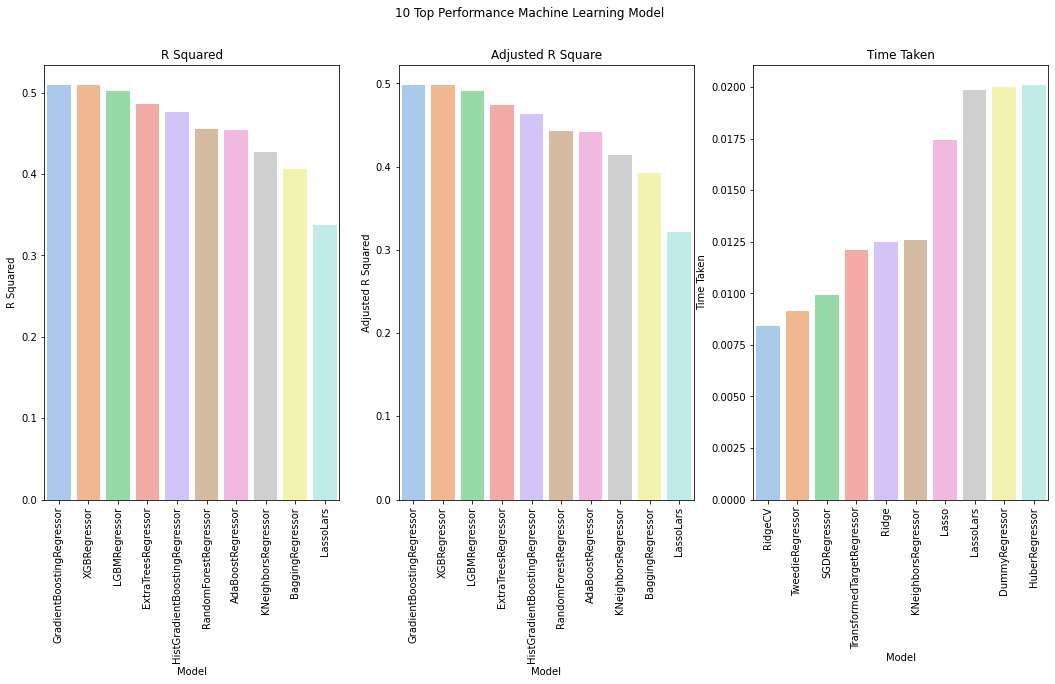

In [45]:
fig, ax = plt.subplots(1, 3, figsize = (18, 8))
plt.suptitle('10 Top Performance Machine Learning Model')

ax[0] = sns.barplot(data = model_score.sort_values(by = 'R Squared', ascending=False)[0:10], x = 'Model', y = 'R Squared', ax = ax[0], palette = 'pastel')
ax[0].set_title('R Squared')
ax[1] = sns.barplot(data = model_score.sort_values(by = 'Adjusted R Squared', ascending=False)[0:10], x = 'Model', y = 'Adjusted R Squared', ax= ax[1], palette = 'pastel')
ax[1].set_title('Adjusted R Square')
ax[2]= sns.barplot(data = model_score.sort_values(by = 'Time Taken', ascending=True)[0:10], x = 'Model', y = 'Time Taken', ax= ax[2], palette = 'pastel')
ax[2].set_title('Time Taken')


for label in ax[0].get_xticklabels():
    label.set_rotation(90)
for label in ax[1].get_xticklabels():
    label.set_rotation(90)
for label in ax[2].get_xticklabels():
    label.set_rotation(90)
plt.show()

In [ ]:
The data has quite in a good condition. Leaving the outliers problem that appears many in our dataset
In terms of performance, we get 3 best model performance (R Square & R Adjusted Square), that is :
LGBMRegressor
HistGradientRegressor
XGBRegressor